# About this notebook

This notebook calculates a spectrum for a single photon energy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Multiprocessing
import multiprocessing as mp
from multiprocessing import Pool

# For the progress bar
from ipywidgets import IntProgress
from IPython.display import display

# This package
import XNLdyn

%matplotlib notebook

In [16]:

pulse_energy_max = 5e-8 # Joule

N_local_fluences_to_calculate = 30
N_pulse_energies = 10

Nsteps_r = 100

pulse_profile_sigma= 400 # nm rms



## Set up the problem and modify the parameters a little
PAR = XNLdyn.XNLpars()
PAR.N_photens = 1
PAR.t0_i       = [0,]   # Arrival time on time-axis / fs
PAR.tdur_sig_i = [10,]  # Rms pulse duration / fs
PAR.E_i_abs    = [848.4,] # Photon Energies of incident pulses / eV
PAR.lambda_res_Ei = (600,)
PAR.I0_i =  [XNLdyn.photons_per_J(PAR.E_i_abs[0])*pulse_energy_max]

#* XNLdyn.photons_per_J(PAR.E_i_abs[0])

PAR.Nsteps_z = 20



In [17]:
pulse_energy_max_photons = pulse_energy_max *  XNLdyn.photons_per_J(PAR.E_i_abs[0])
pulse_energy_max_photons/PAR.atomic_density

4024507.6292797523

Starting to generate lookup tables for T between 301.0 to 1000300.0 and Ef between -31.6 and 31.6
Lookup tables generated.
Saving at ./fermi_lookup_table.npz


<IPython.core.display.Javascript object>


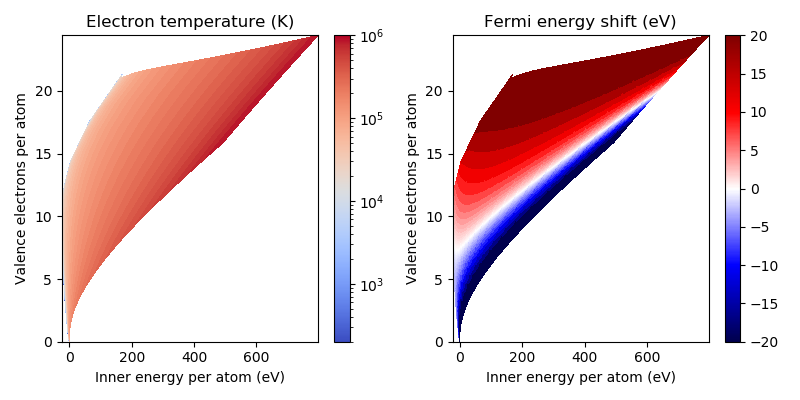

<IPython.core.display.Javascript object>


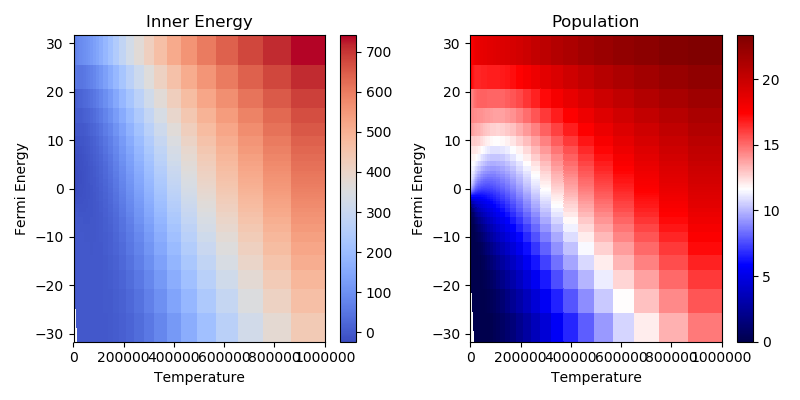

In [18]:
sim = XNLdyn.XNLsim(PAR, DEBUG=True, load_tables = False)
PAR.FermiSolver.plot_lookup_tables()

In [ ]:
plt.figure()
plt.plot(PAR.E_j,PAR.m_j/PAR.enax_dE_j)
plt.plot(PAR.E_j,PAR.FermiSolver.fermi(1e5,0)*PAR.m_j/PAR.enax_dE_j)
plt.plot(PAR.E_j,PAR.FermiSolver.fermi(1e5,10)*PAR.m_j/PAR.enax_dE_j)
plt.plot(PAR.E_j,PAR.FermiSolver.fermi(1e6,0)*PAR.m_j/PAR.enax_dE_j)

## Run a simulation for a single Fluence

In [19]:
%%time
fluences_joules_nm2, dA = XNLdyn.calculate_fluences(Nsteps_r, pulse_energy_max, pulse_profile_sigma) 
# These are just to get an idea where to calculate Fluences

fluences_simulated = np.logspace(np.log10(np.min(fluences_joules_nm2)),
                                 np.log10(np.max(fluences_joules_nm2)),
                                 N_local_fluences_to_calculate)


CPU times: user 437 µs, sys: 0 ns, total: 437 µs
Wall time: 423 µs


Simulating for  0.04191683735791132 photons per atom
Initializing a simulation where ['I0_i'] are changed to [2298.7193607078566]

Loaded lookup table successfully.


<IPython.core.display.Javascript object>


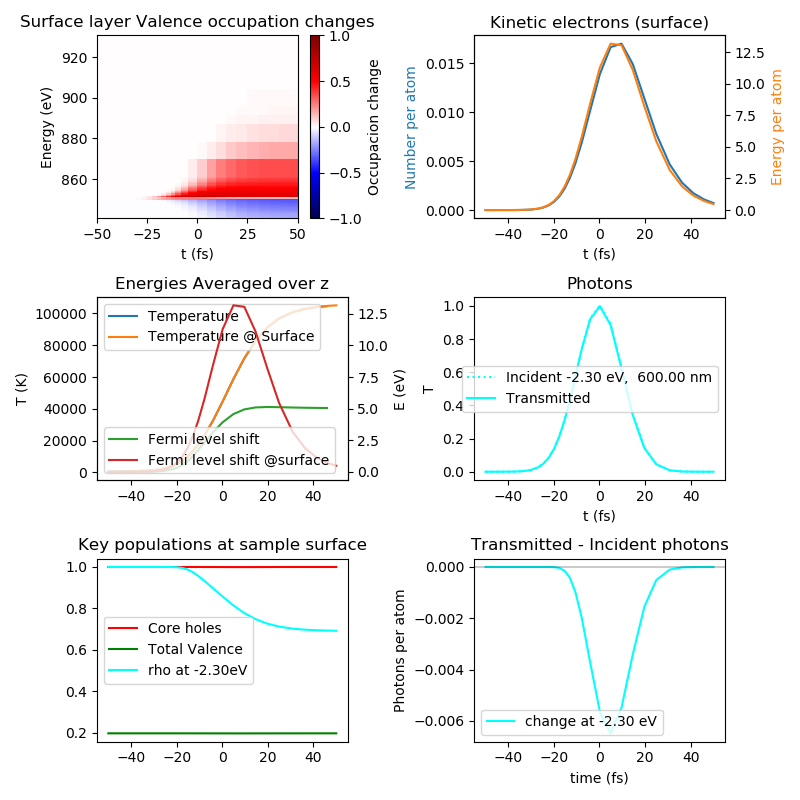

Transmission:  [99.45652485]  %
CPU times: user 30.6 s, sys: 246 ms, total: 30.8 s
Wall time: 30.5 s


(array([25.12259882]), array([24.98606374]))

In [20]:
%%time

print('Simulating for ', 1.0*np.max(fluences_joules_nm2)* XNLdyn.photons_per_J(PAR.E_i_abs[0])/(PAR.atomic_density*PAR.lambda_res_Ei[0]) ,'photons per atom')

XNLdyn.run_modified_simulation(PAR, dict(t_span=[-50, 50],method='RK45', rtol=1e-3, atol=1e-8, plot = True),
                               ['I0_i',] , [1.0*np.max(fluences_joules_nm2)* XNLdyn.photons_per_J(PAR.E_i_abs[0]),])

# Load a spectrum to simulate

<IPython.core.display.Javascript object>


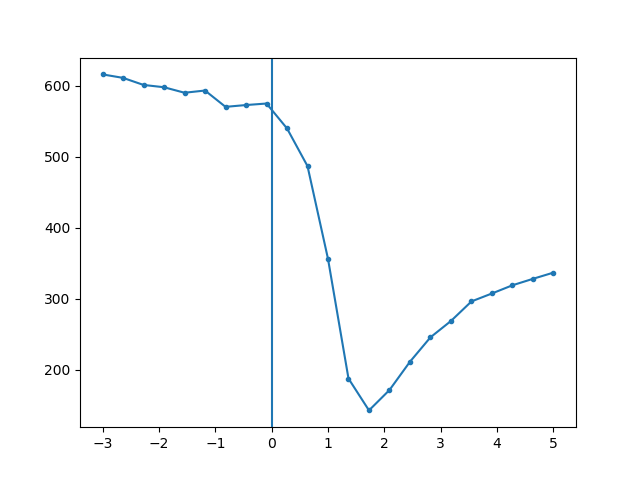

In [39]:
N_points_E = 23
E_fermi = 850.7
Erange = 3
E_min, E_max = E_fermi-Erange, E_fermi+Erange
enax_abs = np.linspace(E_min, E_max+2, N_points_E) # Absolute energy axis to sample
enax_rel = enax_abs-E_fermi # Rélative energy axis to Fermi Energy, i.e. detuning

ld = np.load('../../Penetration_depth_cold_spectrum.npz', allow_pickle=True)
pendepths = np.interp(enax_abs, ld['enax'],ld['spectrum'])

plt.figure()
plt.plot(enax_rel, pendepths,'.-')
plt.axvline()
#plt.axvline(E_fermi)

## Run it for all the fluences in the spot

TODO: Find solution for low temperature error
      and high temperature Error
TODO: Properly integrate FEG model following PHYSICAL REVIEW E 102, 063204 (2020)

In [40]:
sim_options = dict(t_span=[-50, 50],method='RK45', rtol=1e-3, atol=1e-8, plot = False)

In [41]:
%%time
print(f'I will run {N_points_E*N_local_fluences_to_calculate:.0f} Simualtions')

timeout = 300

progressbar = IntProgress(min=0, max=N_points_E*N_local_fluences_to_calculate) # instantiate the bar
display(progressbar) # display the bar

try:
    mp.set_start_method('fork')  # 'spawn' on windows, "fork" or "forkserver" on unix machines
except RuntimeError:
    pass
with Pool(processes=50) as pool:
    tasklist = {}
    for photon_energy, pendepdth in zip(enax_abs, pendepths):
        for fluence in fluences_simulated:
            progressbar.value += 1
            fluence_photons = fluence* XNLdyn.photons_per_J(photon_energy)
            tasklist[(photon_energy,fluence)]=\
                pool.apply_async(XNLdyn.run_modified_simulation,(*(PAR, sim_options,
                                            ['I0_i','E_i_abs', 'lambda_res_Ei'] ,
                                            [(fluence_photons,),(photon_energy,),(pendepdth,)]),)
                                             )


    #tasklist = [pool.apply_async(XNLdyn.run_modified_simulation,(*(PAR, sim_options,  ['I0',] , [fluence,]),)
    #                                     ) for fluence in fluences_simulated]
    resultdict = {key: tasklist[key].get(timeout=timeout) for key in tasklist}


I will run 690 Simualtions


IntProgress(value=0, max=690)

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.012351209470978083,), (847.7,), (615.9438308554943,)]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.018768876574107914,), (847.7,), (615.9438308554943,)]

Loaded lookup table successfully.
Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.0285211524168413,), (847.7,), (615.9438308554943,)]

Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.04334069393939467,), (847.7,), (615.9438308554943,)]

Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.06586044363477832,), (847.7,), (615.9438308554943,)]

Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.10008141636668862,), (847.7,), 

Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(9.981225946722052,), (848.0636363636364,), (611.0454769005596,)]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(15.167453705039833,), (848.0636363636364,), (611.0454769005596,)]

Loaded lookup table successfully.
Loaded lookup table successfully.
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(23.048436446835474,), (848.0636363636364,), (611.0454769005596,)]

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(35.02436420605605,), (848.0636363636364,), (611.0454769005596,)]

Loaded lookup table successfully.
Loaded lookup table successfully.
Transmission:  [99.99999794]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(53.22296333931563,), (848.0636363636364,), (611.0454769005596,)]

Loaded lookup table successfully.
Tr

Transmission:  [99.81331135]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(283.6795551962317,), (848.4272727272728,), (601.0943413648263,)]

Loaded lookup table successfully.
Transmission:  [99.99943862]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(431.0789619904565,), (848.4272727272728,), (601.0943413648263,)]

Loaded lookup table successfully.
Transmission:  [99.99964274]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(655.0668459072582,), (848.4272727272728,), (601.0943413648263,)]

Loaded lookup table successfully.
Transmission:  [99.99999865]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(995.4384473450214,), (848.4272727272728,), (601.0943413648263,)]

Loaded lookup table successfully.
Transmission:  [99.99522636]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(1512.66654


Loaded lookup table successfully.
Transmission:  [99.99916058]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.028472297573128358,), (849.1545454545455,), (590.1068497936259,)]

Loaded lookup table successfully.
Transmission:  [99.84505342]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.043266454203290276,), (849.1545454545455,), (590.1068497936259,)]

Loaded lookup table successfully.
!!
Transmission:  [99.93495132]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.06574762906005088,), (849.1545454545455,), (590.1068497936259,)]

Loaded lookup table successfully.
Transmission:  [99.99999789]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.09990998353383165,), (849.1545454545455,), (590.1068497936259,)]

Loaded lookup table successfully.
!!
Transmission:  [99.70411898]  %
Initializing a simulation where ['I0_i', 'E_i


Loaded lookup table successfully.
Transmission:  [99.98541844]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.8092205508085173,), (849.5181818181819,), (593.2298736075008,)]

Loaded lookup table successfully.
Transmission:  [99.97055346]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(1.2296901509965248,), (849.5181818181819,), (593.2298736075008,)]

Loaded lookup table successfully.
Transmission:  [99.9999996]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(1.8686350290375497,), (849.5181818181819,), (593.2298736075008,)]

Loaded lookup table successfully.
Transmission:  [99.99997895]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(2.8395745618653963,), (849.5181818181819,), (593.2298736075008,)]

Loaded lookup table successfully.
Transmission:  [99.99999442]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambd


Loaded lookup table successfully.
Transmission:  [99.9999973]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(22.99912812279719,), (849.8818181818182,), (570.2362981394441,)]

Loaded lookup table successfully.
Transmission:  [99.99999469]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(34.94943536203271,), (849.8818181818182,), (570.2362981394441,)]

Loaded lookup table successfully.
Transmission:  [99.82072577]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(53.10910159738508,), (849.8818181818182,), (570.2362981394441,)]

Loaded lookup table successfully.
Transmission:  [99.99996865]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(80.70449903592656,), (849.8818181818182,), (570.2362981394441,)]

Loaded lookup table successfully.
Transmission:  [99.7607358]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res

Loaded lookup table successfully.
Transmission:  [99.90081355]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(34.934488048267895,), (850.2454545454545,), (572.7837150948321,)]

Energy -0.45 too close to others to satisfy the resonant bandwidth of 0.40
Loaded lookup table successfully.
Transmission:  [99.80502212]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(53.08638768521109,), (850.2454545454545,), (572.7837150948321,)]

Energy -0.45 too close to others to satisfy the resonant bandwidth of 0.40
Loaded lookup table successfully.
Transmission:  [99.99962044]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(80.66998301422761,), (850.2454545454545,), (572.7837150948321,)]

Energy -0.45 too close to others to satisfy the resonant bandwidth of 0.40
Loaded lookup table successfully.
Transmission:  [99.999166]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lam

!!
!!
!!
!!
Transmission:  [99.9792411]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(6.5486762051319,), (850.6090909090909,), (574.9287656084659,)]

Energy -0.09 too close to others to satisfy the resonant bandwidth of 0.40
Loaded lookup table successfully.
!!
!!
!!
!!
Transmission:  [99.99710511]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(9.951357047803821,), (850.6090909090909,), (574.9287656084659,)]

Energy -0.09 too close to others to satisfy the resonant bandwidth of 0.40
Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [99.99919565]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(15.122064977845298,), (850.6090909090909,), (574.9287656084659,)]

Energy -0.09 too close to others to satisfy the resonant b

!!
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.043174011428277106,), (850.9727272727273,), (539.8720596308922,)]

Energy 0.27 too close to others to satisfy the resonant bandwidth of 0.40
!!
!!
Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [99.82828498]  %
!!
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.06560715317884531,), (850.9727272727273,), (539.8720596308922,)]

Energy 0.27 too close to others to satisfy the resonant bandwidth of 0.40
!!
Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!

Loaded lookup table successfully.
!!
Transmission:  [99.85646998]  %
!!
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(6.545877834836887,), (850.9727272727273,), (539.8720596308922,)]

!!
Energy 0.27 too close to others to satisfy the resonant bandwidth of 0.40
Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
Transmission:  [99.81341531]  %
!!
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(9.94710464913799,), (850.9727272727273,), (539.8720596308922,)]

!!
Energy 0.27 too close to others to satisfy the resonant bandwidth of 0.40
!!
Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [99.75707907]  %
!!
Initializing a simulation where ['I0_i', 'E_i_abs', 'l

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.06557913000536242,), (851.3363636363637,), (486.77610566794067,)]

Energy 0.64 too close to others to satisfy the resonant bandwidth of 0.40
Loaded lookup table successfully.
Transmission:  [95.70272992]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.09965393266142658,), (851.3363636363637,), (486.77610566794067,)]

Energy 0.64 too close to others to satisfy the resonant bandwidth of 0.40
Loaded lookup table successfully.
Transmission:  [99.05883754]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.151433943909841,), (851.3363636363637,), (486.77610566794067,)]

Energy 0.64 too close to others to satisfy the resonant bandwidth of 0.40
Loaded lookup table successfully.
Transmission:  [99.26093381]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.23011875954761143,), (851.336


Loaded lookup table successfully.
Transmission:  [96.35150456]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.043137144830838164,), (851.7,), (356.15973036916097,)]

Loaded lookup table successfully.
Transmission:  [99.0940209]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.06555113076106796,), (851.7,), (356.15973036916097,)]

Loaded lookup table successfully.
Transmission:  [96.20917898]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.0996113850581683,), (851.7,), (356.15973036916097,)]

Loaded lookup table successfully.
Transmission:  [99.03508835]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.15136928864543508,), (851.7,), (356.15973036916097,)]

Loaded lookup table successfully.
Transmission:  [96.52731539]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.2300205095

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(1.2260165751616101,), (852.0636363636364,), (187.52293083608203,)]

Loaded lookup table successfully.
Transmission:  [93.54877583]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(1.8630526695452954,), (852.0636363636364,), (187.52293083608203,)]

Loaded lookup table successfully.
Transmission:  [93.54860776]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(2.831091618025069,), (852.0636363636364,), (187.52293083608203,)]

Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
Transmission:  [97.47525778]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(4.302121931747676,), (852.0636363636364,), (187.52293083608203,)]

Loaded lookup table successfully.
Transmission:  [96.89182065]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(6.5374970551236


Loaded lookup table successfully.
Transmission:  [96.74718518]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(34.845071972979305,), (852.4272727272728,), (142.68093794199604,)]

Loaded lookup table successfully.
Transmission:  [95.58083459]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(52.950511171678066,), (852.4272727272728,), (142.68093794199604,)]

Loaded lookup table successfully.
Transmission:  [88.10230588]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(80.46350529900354,), (852.4272727272728,), (142.68093794199604,)]

Loaded lookup table successfully.
Transmission:  [88.10216079]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(122.27220364334808,), (852.4272727272728,), (142.68093794199604,)]

Loaded lookup table successfully.
Transmission:  [93.54857784]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'l

Transmission:  [84.66284955]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(651.7149416140232,), (852.7909090909092,), (171.40111276842603,)]

Loaded lookup table successfully.
Transmission:  [84.66437376]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(990.3448993717825,), (852.7909090909092,), (171.40111276842603,)]

Loaded lookup table successfully.
Transmission:  [84.66281945]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(1504.9263981622394,), (852.7909090909092,), (171.40111276842603,)]

Loaded lookup table successfully.
Transmission:  [93.29972952]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(2286.8835547315193,), (852.7909090909092,), (171.40111276842603,)]

Loaded lookup table successfully.
Transmission:  [91.75732056]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.01

Loaded lookup table successfully.
Transmission:  [87.06304107]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.06541149240695915,), (853.5181818181819,), (245.65492590020762,)]

Loaded lookup table successfully.
Transmission:  [92.51986347]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.09939919085650424,), (853.5181818181819,), (245.65492590020762,)]

Loaded lookup table successfully.
Transmission:  [87.0676728]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.15104683870317379,), (853.5181818181819,), (245.65492590020762,)]

Loaded lookup table successfully.
Transmission:  [87.08087739]  %

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.22953051514432418,), (853.5181818181819,), (245.65492590020762,)]
Loaded lookup table successfully.
Transmission:  [89.36481137]  %
Initializing a simulation where ['I0_i', 'E_i_abs',

!!
!!
!!
Transmission:  [90.78348811]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(1.2234060018969226,), (853.8818181818182,), (268.66500986078177,)]

Loaded lookup table successfully.
Transmission:  [90.78345211]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(1.859085646922311,), (853.8818181818182,), (268.66500986078177,)]

Loaded lookup table successfully.
Transmission:  [90.78345959]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(2.8250633373006235,), (853.8818181818182,), (268.66500986078177,)]

Loaded lookup table successfully.
Transmission:  [90.78344709]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(4.292961366773286,), (853.8818181818182,), (268.66500986078177,)]

Loaded lookup table successfully.
Transmission:  [89.51619469]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed 

Transmission:  [90.87335053]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(22.881644522182693,), (854.2454545454545,), (296.1928433854505,)]

Loaded lookup table successfully.
Transmission:  [91.27000492]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(34.77090748550397,), (854.2454545454545,), (296.1928433854505,)]

Loaded lookup table successfully.
Transmission:  [91.00920129]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(52.837810944637354,), (854.2454545454545,), (296.1928433854505,)]

Loaded lookup table successfully.
!!
!!
!!
!!
!!
!!
!!
!!
Transmission:  [91.67411576]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(80.29224622869376,), (854.2454545454545,), (296.1928433854505,)]

Loaded lookup table successfully.
!!
Transmission:  [91.53862052]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'


Loaded lookup table successfully.
Transmission:  [92.29389664]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(650.3284173304827,), (854.6090909090909,), (307.3948025126739,)]

Loaded lookup table successfully.
Transmission:  [94.29595101]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(988.2379394658782,), (854.6090909090909,), (307.3948025126739,)]

Loaded lookup table successfully.
Transmission:  [92.29402]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(1501.7246655292179,), (854.6090909090909,), (307.3948025126739,)]

Loaded lookup table successfully.
Transmission:  [95.28196415]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(2282.018207353704,), (854.6090909090909,), (307.3948025126739,)]

Loaded lookup table successfully.
Transmission:  [92.29413017]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.042953752248097346,), (855.3363636363637,), (328.00728885283706,)]

Loaded lookup table successfully.
Transmission:  [92.56578645]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.06527244770916464,), (855.3363636363637,), (328.00728885283706,)]

Loaded lookup table successfully.
Transmission:  [92.56675046]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.09918789877394978,), (855.3363636363637,), (328.00728885283706,)]

Loaded lookup table successfully.
Transmission:  [92.56821735]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.15072575961955292,), (855.3363636363637,), (328.00728885283706,)]

Loaded lookup table successfully.
Transmission:  [95.45946842]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(0.22904260392355122,), (855.3

Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(1.22080652246616,), (855.7,), (336.7723912780126,)]

Loaded lookup table successfully.
Transmission:  [93.09503161]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(1.8551354824701936,), (855.7,), (336.7723912780126,)]

Loaded lookup table successfully.
Transmission:  [93.01455761]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(2.819060674223503,), (855.7,), (336.7723912780126,)]

Loaded lookup table successfully.
Transmission:  [92.82940433]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(4.283839730331515,), (855.7,), (336.7723912780126,)]

Loaded lookup table successfully.
Transmission:  [93.01458178]  %
Initializing a simulation where ['I0_i', 'E_i_abs', 'lambda_res_Ei'] are changed to [(6.5097154534360655,), (855.7,), (336.7723912780126,)]

Loaded lookup table successfully.
T

## Assemble the results into a Matrix

In [42]:
fl_dep_spectrum_I = np.zeros((N_points_E,N_local_fluences_to_calculate))
fl_dep_spectrum_T = np.zeros((N_points_E,N_local_fluences_to_calculate))

for i_photen in range(N_points_E):
    for i_pulseen in range(N_local_fluences_to_calculate):
        fl_dep_spectrum_I[i_photen, i_pulseen], fl_dep_spectrum_T[i_photen, i_pulseen]  = \
            resultdict[(enax_abs[i_photen],fluences_simulated[i_pulseen])]


<IPython.core.display.Javascript object>


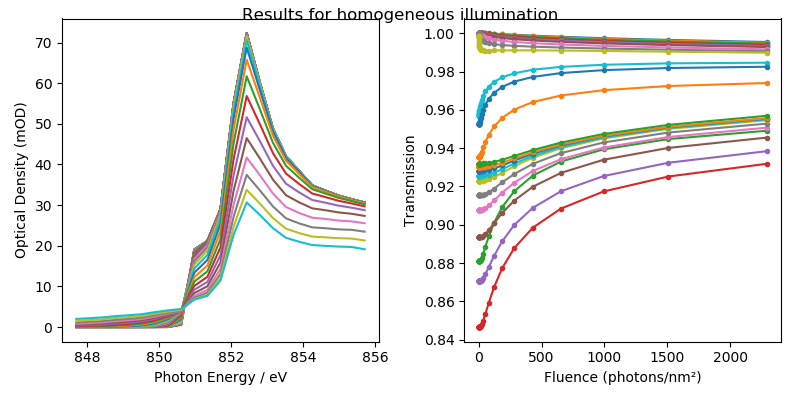

In [43]:
T = fl_dep_spectrum_T/fl_dep_spectrum_I

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))
fig.suptitle('Results for homogeneous illumination')
ax1.plot(enax_abs,1e3*np.log10(1/T))
ax1.set_ylabel('Optical Density (mOD)')
ax1.set_xlabel('Photon Energy / eV')

plt.sca(ax2)
plt.plot(fluences_simulated*XNLdyn.photons_per_J(850), T[:,:].T, '.-')#, label ='For one z-stack'
plt.xlabel('Fluence (photons/nm²)')
plt.ylabel('Transmission')
#plt.xscale('log')
#plt.legend(loc = 'lower right')

plt.tight_layout()


<IPython.core.display.Javascript object>


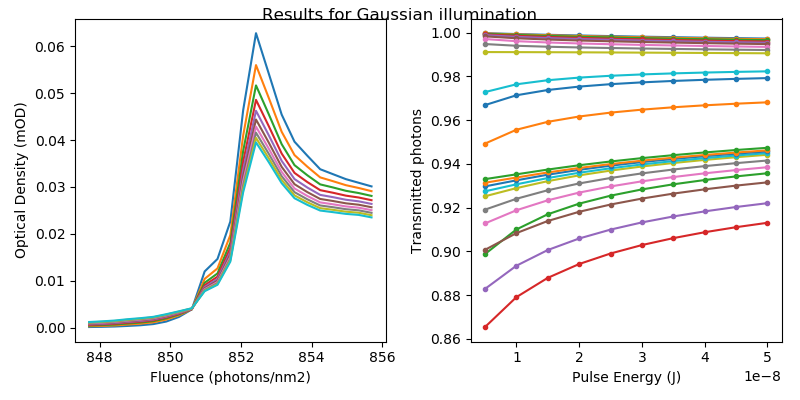

In [44]:
# These are the pulse energies for which we evaluate stuff
final_pulse_energies = np.linspace(1/N_pulse_energies, 1, N_pulse_energies)* pulse_energy_max

final_transmissions = np.zeros((N_points_E, N_pulse_energies))
final_incidence_check = np.zeros((N_points_E, N_pulse_energies))
for i_photen in range(N_points_E):

    for ipe, pulse_en in enumerate(final_pulse_energies*XNLdyn.photons_per_J(enax_abs[i_photen])):
        local_fluences, dA = XNLdyn.calculate_fluences(Nsteps_r, pulse_en, pulse_profile_sigma)
        
        
        local_transmitted = np.interp(local_fluences, fluences_simulated*XNLdyn.photons_per_J(enax_abs[i_photen]),
                                      fl_dep_spectrum_T[i_photen,:])# tr[:, 0]
        final_transmissions[i_photen,ipe] = np.sum(local_transmitted*dA)

        
        local_incidence_check = np.interp(local_fluences, fluences_simulated*XNLdyn.photons_per_J(enax_abs[i_photen]),
                                          fl_dep_spectrum_I[i_photen,:])

        final_incidence_check[i_photen,ipe] = np.sum(local_incidence_check*dA) # should result equal final_pulse_energies

        
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8,4))
fig.suptitle('Results for Gaussian illumination')

plt.sca(ax1)
plt.plot(enax_abs,np.log10(final_incidence_check/final_transmissions) )#, label ='For one z-stack'
plt.xlabel('Fluence (photons/nm2)')
plt.ylabel('Optical Density (mOD)')

plt.sca(ax2)
plt.plot(final_pulse_energies, (final_transmissions/final_incidence_check).T, '.-')

plt.xlabel('Pulse Energy (J)')
plt.ylabel('Transmitted photons')
#plt.legend(loc = 'lower left')
plt.tight_layout()

<IPython.core.display.Javascript object>


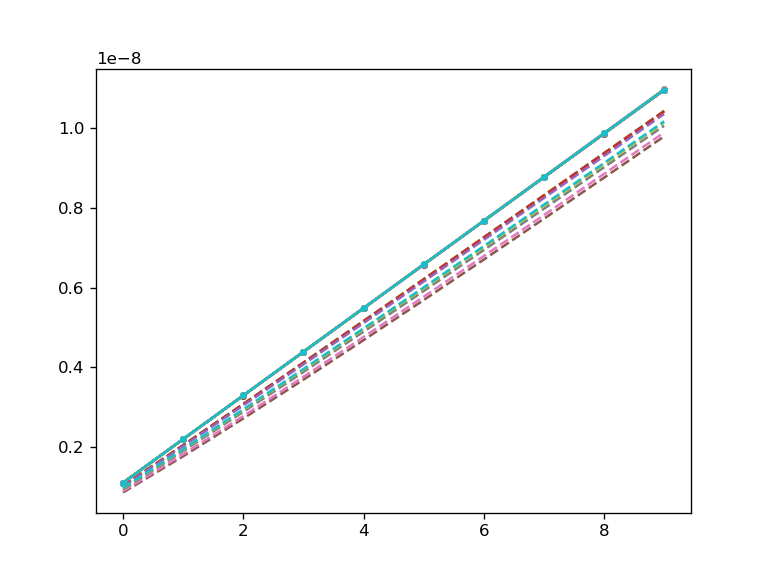

In [23]:
plt.figure()
plt.plot((1/XNLdyn.photons_per_J(enax_abs))*final_transmissions.T,'--')
plt.plot((1/XNLdyn.photons_per_J(enax_abs))*final_incidence_check.T,'.-')
#plt.plot(final_pulse_energies,'x')